<a href="https://colab.research.google.com/github/Hacxmr/log-analysis/blob/main/NSS_KDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install imbalanced-learn tensorflow


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load dataset
df = pd.read_csv("/content/kdd_dataset.csv")
df.drop(columns=["Unnamed: 0", "difficulty"], inplace=True, errors='ignore')

# 2. Split features and labels
X = df.drop(columns=["class"])
y = df["class"]

# 3. One-hot encode categorical features
X_encoded = pd.get_dummies(X).astype('float32')

# 4. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# 5. Convert labels to integer class indices
label_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_class_indices = pd.Series(y).astype('category').cat.codes
y_classes = pd.Series(y).astype('category').cat.categories
y_encoded = label_encoder.fit_transform(y_class_indices.values.reshape(-1, 1)).astype('float32')

# 6. Train-test split using class indices
X_train, X_test, y_train_indices, y_test_indices = train_test_split(
    X_scaled, y_class_indices, test_size=0.2, random_state=42
)

# 7. Filter rare classes in train set
(unique_classes, counts) = np.unique(y_train_indices, return_counts=True)
valid_classes = unique_classes[counts > 3]
train_mask = np.isin(y_train_indices, valid_classes)
X_train = X_train[train_mask]
y_train_indices = y_train_indices[train_mask]

# 8. Also filter test set to match training classes
test_mask = np.isin(y_test_indices, valid_classes)
X_test = X_test[test_mask]
y_test_indices = y_test_indices[test_mask]

# 9. Re-encode filtered labels
label_encoder = OneHotEncoder(sparse_output=False)
y_train = label_encoder.fit_transform(y_train_indices.to_numpy().reshape(-1, 1)).astype('float32')
y_test = label_encoder.transform(y_test_indices.to_numpy().reshape(-1, 1)).astype('float32')


# 10. Apply SMOTE
smote = SMOTE(k_neighbors=2, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 11. Build model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_res.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_res.shape[1], activation='softmax')
])

# 12. Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 13. Early stopping
es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# 14. Train model
history = model.fit(
    X_train_res, y_train_res,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[es],
    verbose=1
)

# 15. Evaluate on test set
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
13476/13476 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.8953 - loss: 0.3373 - val_accuracy: 0.4126 - val_loss: 6.0080
Epoch 2/50
13476/13476 ━━━━━━━━━━━━━━━━━━━━ 70s 5ms/step - accuracy: 0.9703 - loss: 0.0806 - val_accuracy: 0.4622 - val_loss: 5.1988
Epoch 3/50
13476/13476 ━━━━━━━━━━━━━━━━━━━━ 70s 5ms/step - accuracy: 0.9751 - loss: 0.0684 - val_accuracy: 0.4300 - val_loss: 4.9472
Epoch 4/50
13476/13476 ━━━━━━━━━━━━━━━━━━━━ 68s 5ms/step - accuracy: 0.9777 - loss: 0.0624 - val_accuracy: 0.4795 - val_loss: 4.4794
Epoch 5/50
13476/13476 ━━━━━━━━━━━━━━━━━━━━ 70s 5ms/step - accuracy: 0.9792 - loss: 0.0582 - val_accuracy: 0.4801 - val_loss: 4.4944
Epoch 6/50
13476/13476 ━━━━━━━━━━━━━━━━━━━━ 71s 5ms/step - accuracy: 0.9804 - loss: 0.0551 - val_accuracy: 0.4022 - val_loss: 5.3497
Epoch 7/50
13476/13476 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - accuracy: 0.9813 - loss: 0.0530 - val_accuracy: 0.3371 - val_loss: 5.6609
Epoch 8/50
13476/13476 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 

929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_


Classification Report:
                  precision    recall  f1-score   support

        apache2       1.00      1.00      1.00       150
           back       0.85      1.00      0.92       271
buffer_overflow       0.09      0.82      0.17        11
      ftp_write       0.00      0.00      0.00         0
   guess_passwd       0.89      1.00      0.94       243
     httptunnel       0.86      0.94      0.90        32
           imap       0.50      0.33      0.40         3
        ipsweep       0.90      0.99      0.95       698
           land       0.82      1.00      0.90         9
     loadmodule       0.00      0.00      0.00         2
       mailbomb       0.96      1.00      0.98        50
          mscan       0.96      1.00      0.98       215
       multihop       0.04      0.50      0.08         4
          named       0.50      0.20      0.29         5
        neptune       1.00      1.00      1.00      9147
           nmap       0.96      0.97      0.97       333
     

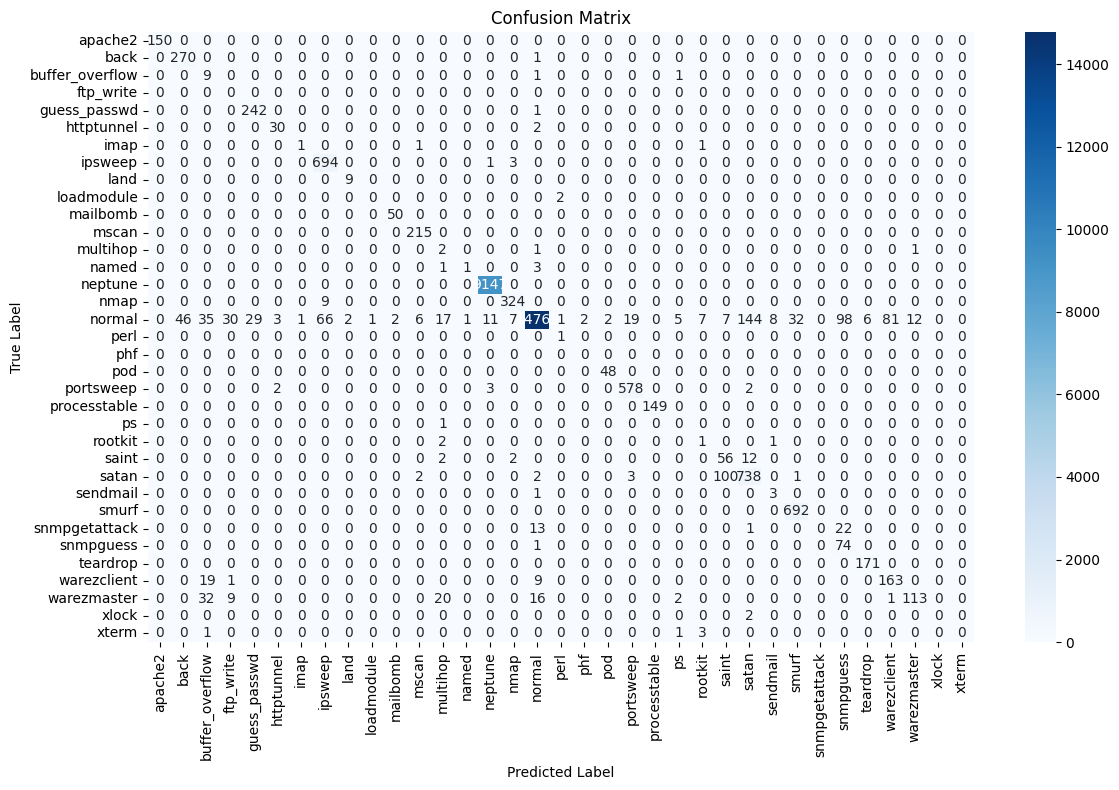

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 16. Predict on test set
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 17. Classification report
report = classification_report(
    y_true_classes, y_pred_classes, target_names=y_classes[valid_classes]
)
print("\nClassification Report:\n", report)

# 18. Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:\n", conf_matrix)

# (Optional) 19. Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=y_classes[valid_classes],
            yticklabels=y_classes[valid_classes])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
